# **Load & Plot Historical Data**

Saving LZS.xlsx to LZS.xlsx


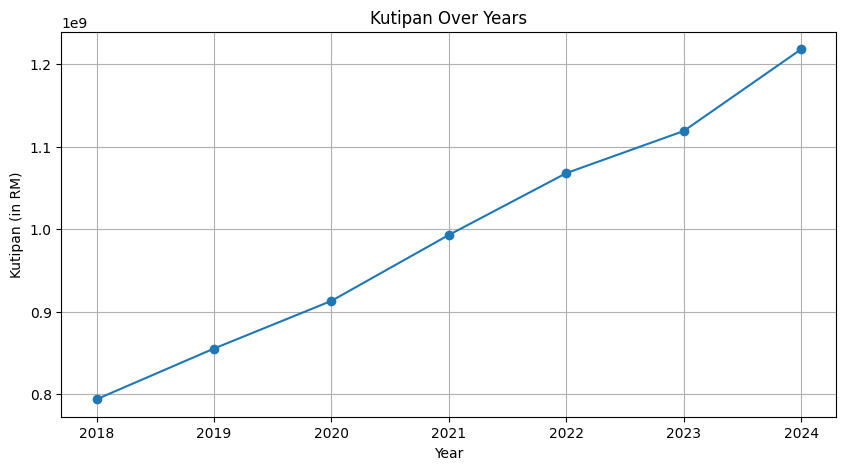

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Upload Excel file
uploaded = files.upload()

# Get the file name
file_name = next(iter(uploaded))

# Read Excel file into DataFrame
data = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='By Year (2)')

#################################################

# Set 'Tahun' as the index
data.set_index('Tahun', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Kutipan'], marker='o')
plt.title('Kutipan Over Years')
plt.xlabel('Year')
plt.ylabel('Kutipan (in RM)')
plt.grid(True)
plt.show()


# **Stationarity Test**

In [ ]:
#################################################

# Stationarity test - checks whether time series (Kutipan) is stationary — meaning its statistical properties (mean, variance, autocorrelation) don’t change over time. ARIMA models require the input data to be stationary
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

stationarity_test = test_stationarity(data['Kutipan'])

# Differencing
data['first_difference'] = data['Kutipan'].diff()

# ADF test on differenced data
result = adfuller(data['first_difference'].dropna())
#If p-value < 0.05 → the series is stationary (good for ARIMA), If p-value ≥ 0.05 → not stationary → need differencing')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

#################################################

ADF Statistic: -2.668888231053437
p-value: 0.07957841741755489
Critical Values: {'1%': np.float64(-6.045114), '5%': np.float64(-3.9292800000000003), '10%': np.float64(-2.98681)}


In [ ]:
# First-order Differencing
data['first_difference'] = data['Kutipan'].diff()
result = adfuller(data['first_difference'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.9462687111499026
p-value: 0.3106174425380649
Critical Values: {'1%': np.float64(-5.354256481481482), '5%': np.float64(-3.6462381481481483), '10%': np.float64(-2.901197777777778)}


In [ ]:
# Cleans up the extra column once done using it
data.drop(['first_difference'], axis=1, inplace=True)

In [ ]:
# Second-order Differencing
data['second_difference'] = data['Kutipan'].diff().diff()
result = adfuller(data['second_difference'].dropna())
print("ADF Statistic (2nd diff):", result[0])
print("p-value:", result[1])

ADF Statistic (2nd diff): 1.472729081524527
p-value: 0.9974207419448334


In [ ]:
# Cleans up the extra column once done using it
data.drop(['second_difference', 'log_jumlah', 'log_diff'], axis=1, errors='ignore', inplace=True)

# **Identifying ARIMA Parameters**

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 3 must be < 2.

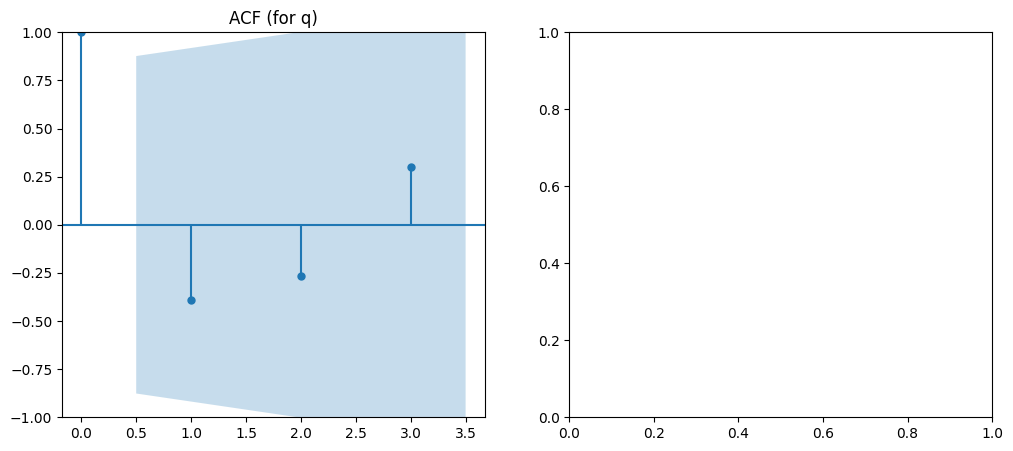

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Second-order differencing (already dropped NA in this step)
diff_series = data['Kutipan'].diff().diff().dropna()

# Auto-determine safe number of lags (must be < number of data points)
max_lags = min(len(diff_series) - 1, 3)  # 3 is safe for 4 data points

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(diff_series, lags=max_lags, ax=axes[0])
axes[0].set_title('ACF (for q)')
plot_pacf(diff_series, lags=max_lags, ax=axes[1])
axes[1].set_title('PACF (for p)')
plt.tight_layout()
plt.show()


# In ACF:
#A sharp drop after lag 1 suggests q = 1
#In PACF:
#A sharp drop after lag 2 suggests p = 2


# **Exogenous Variables**

In [ ]:
#################################################

# Adding Exogenous Variables (Exog)
# Real data for Malaysia (2018 - 2024) #to double check with dosm #to test p value to testing relevance
exogenous_data = pd.DataFrame({
    'Inflation': [ 1.0, 0.7, -1.1, 2.5, 3.4, 2.5, 1.8],  # Actual inflation data from 2018 to 2024 #source:https://open.dosm.gov.my/data-catalogue/cpi_annual_inflation
    'GDP_growth': [ 4.8, 4.4, -5.5, 3.3, 8.9, 3.6, 5.1],  # Actual GDP growth from 2018 to 2024 # #source:https://open.dosm.gov.my/data-catalogue/gdp_gni_annual_real?series=growth-yoy&visual=table
    'Unemployment_rate': [ 3.3, 3.3, 4.5, 4.6, 3.9, 3.4, 3.3],  # Actual unemployment rate from 2018 to 2024 #source https://open.dosm.gov.my/data-catalogue/lfs_year
    #'GNI_growth' : [ 4.2, 5.0, -5.0, 2.8, 8.3, 4.0, 4.7],  # Actual GNI growth from 2018 to 2024 # #source:https://open.dosm.gov.my/data-catalogue/gdp_gni_annual_real?series=growth-yoy&visual=table
    #'Muzakki_growth_rate' : [ 10.0, -1.0, -4.0],  # Muzakki_growth_rate from 2018 to 2024 # #source:https://open.dosm.gov.my/data-catalogue/gdp_gni_annual_real?series=growth-yoy&visual=table

    # incomplete value #
    #'Retention_rate' : [5.0, -5.0, 2.8, 8.3, 4.0, 4.7],
    #'New_muzakki_ growth_rate' : [5, 6, 11,5, 10, 0.11],

}, index=pd.Index([2018, 2019, 2020, 2021, 2022, 2023, 2024], name='Tahun'))

#################################################

# **Parameters Testing**

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")  # suppress ARIMA convergence warnings

# Define your inputs
y = data['Kutipan']
exog = exogenous_data

# Test different (p,q) combinations — fix d based on earlier differencing
best_aic = np.inf
best_order = None
best_model = None

for p in range(0, 4):      # try p = 0 to 3
    for q in range(0, 4):  # try q = 0 to 3
        try:
            model = ARIMA(y, order=(p, 1, q), exog=exog)
            fitted = model.fit()
            print(f"ARIMA({p},1,{q}) - AIC: {fitted.aic:.2f}")
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, 1, q)
                best_model = fitted
        except Exception as e:
            print(f"ARIMA({p},1,{q}) failed: {e}")
            continue

print("\nBest ARIMAX(p,1,q):", best_order)
print("Lowest AIC:", best_aic)


ARIMA(0,1,0) - AIC: 247.82
ARIMA(0,1,1) - AIC: 243.06
ARIMA(0,1,2) - AIC: 344.47
ARIMA(0,1,3) - AIC: 342.81
ARIMA(1,1,0) - AIC: 294.12
ARIMA(1,1,1) - AIC: 340.25
ARIMA(1,1,2) - AIC: 228.70
ARIMA(1,1,3) - AIC: 230.92
ARIMA(2,1,0) - AIC: 308.61
ARIMA(2,1,1) - AIC: 211089873283.37
ARIMA(2,1,2) - AIC: 227.69
ARIMA(2,1,3) - AIC: 229.53
ARIMA(3,1,0) - AIC: 594600908318.87
ARIMA(3,1,1) - AIC: 553675938097.39
ARIMA(3,1,2) - AIC: 229.66
ARIMA(3,1,3) - AIC: 229.95

Best ARIMAX(p,1,q): (2, 1, 2)
Lowest AIC: 227.6943738133636


# **Model Fitting**

In [ ]:
#################################################

# Define the ARIMAX model with exogenous variables
model_arimax = ARIMA(data['Kutipan'], order=(2, 3, 2), exog=exogenous_data)

# Fit the model
fitted_arimax_model = model_arimax.fit()

# Forecast the next 6 years with the exogenous data
forecast_years = 6
forecast_arimax = fitted_arimax_model.get_forecast(steps=forecast_years, exog=exogenous_data[-6:])
forecast_arimax_conf_int = forecast_arimax.conf_int()

# Display the forecast summary
forecast_arimax.summary_frame()

#################################################

Kutipan,mean,mean_se,mean_ci_lower,mean_ci_upper
7,1.321458e+09,4.837723e+05,1.320510e+09,1.322406e+09
8,1.422967e+09,1.533238e+06,1.419962e+09,1.425972e+09
9,1.552142e+09,3.293394e+06,1.545688e+09,1.558597e+09
10,1.680022e+09,5.873446e+06,1.668510e+09,1.691533e+09
11,1.785072e+09,9.369816e+06,1.766708e+09,1.803437e+09
12,1.938256e+09,1.386978e+07,1.911071e+09,1.965440e+09


# **Visualize Results**

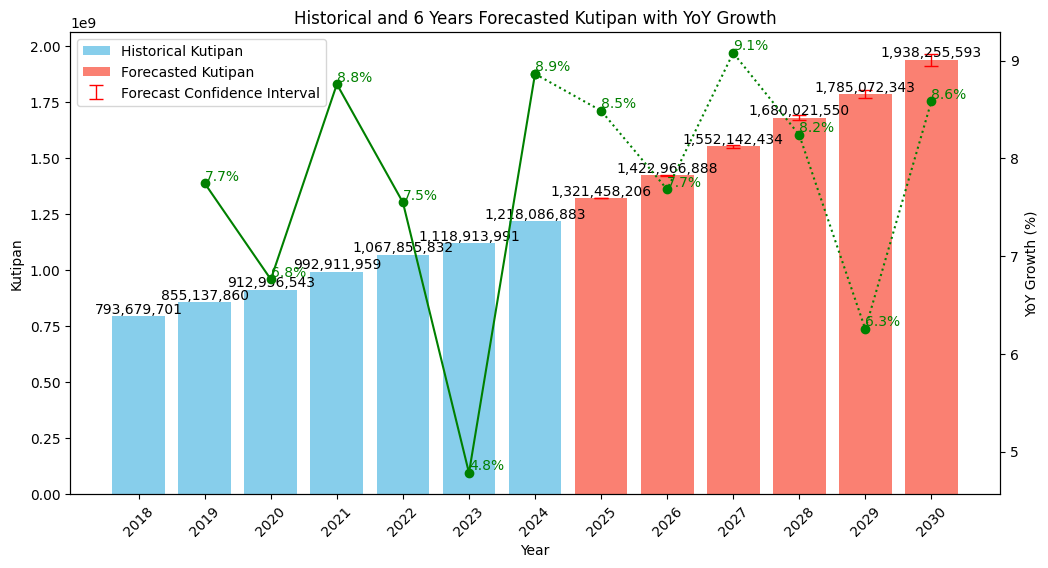

In [ ]:
#################################################

# Visualizing the results
# Extract forecast mean and confidence intervals
forecast_arimax_mean = forecast_arimax.predicted_mean
forecast_arimax_lower_ci = forecast_arimax_conf_int.iloc[:, 0]
forecast_arimax_upper_ci = forecast_arimax_conf_int.iloc[:, 1]

# Combine historical and forecasted data for plotting
historical_data = data['Kutipan']
forecast_arimax_data = pd.Series(forecast_arimax_mean.values, index=range(data.index[-1] + 1, data.index[-1] + 7))

# Convert future predictions to a DataFrame
future_df = pd.DataFrame(forecast_arimax_data, index=forecast_arimax_data.index, columns=['Kutipan'])

# Concatenate the historical and forecasted data
full_df = pd.concat([data, future_df])

#################################################

# Calculate YoY growth
full_df['YoY_Growth'] = full_df['Kutipan'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for historical data
ax1.bar(full_df.index[:len(historical_data)], full_df['Kutipan'][:len(historical_data)], color='skyblue', label='Historical Kutipan')
# Bar chart for forecasted data
ax1.bar(full_df.index[len(historical_data):], full_df['Kutipan'][len(historical_data):], color='salmon', label='Forecasted Kutipan')

# Line chart for YoY growth - historical
ax2 = ax1.twinx()
ax2.plot(full_df.index[:len(historical_data)], full_df['YoY_Growth'][:len(historical_data)], color='green', label='YoY Growth (%)', marker='o')

# Line chart for YoY growth - forecasted (dotted), starting from 2023
ax2.plot(full_df.index[len(historical_data) - 1:], full_df['YoY_Growth'][len(historical_data) - 1:], color='green', linestyle='dotted', marker='o')

# Adding labels
for i, vl in enumerate(zip(full_df.index, full_df['Kutipan'])):
    ax1.text(vl[0], vl[1], f'{vl[1]:,.0f}', ha='center', va='bottom')
for i, vl in enumerate(zip(full_df.index, full_df['YoY_Growth'])):
    if not pd.isna(vl[1]):
        ax2.text(vl[0], vl[1], f'{vl[1]:.1f}%', ha='left', va='bottom', color='green')

# Adding whisker plots for confidence intervals (ARIMAX forecast confidence interval)
error = [forecast_arimax_mean - forecast_arimax_lower_ci, forecast_arimax_upper_ci - forecast_arimax_mean]
ax1.errorbar(forecast_arimax_data.index, forecast_arimax_mean, yerr=error, fmt='none', ecolor='red', elinewidth=1, capsize=5, label='Forecast Confidence Interval')

# Setting titles and labels
ax1.set_title('Historical and 6 Years Forecasted Kutipan with YoY Growth')
ax1.set_xlabel('Year')
ax1.set_ylabel('Kutipan')
ax2.set_ylabel('YoY Growth (%)')

# Setting x-axis ticks to show every year
ax1.set_xticks(full_df.index)
ax1.set_xticklabels(full_df.index, rotation=45)

# Legends
ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

# Show plot
plt.show()

# **Model Accuracy Testing**

In [ ]:
#evaluates how well model predicts the number of Muzakki in 2023–2024 by training the model on 2019–2022 data and comparing the forecasted values to the actuals.


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Split train-test data
train = data.loc[2018:2022]
test = data.loc[2023:2024]
exog_train = exogenous_data.loc[2018:2022]
exog_test = exogenous_data.loc[2023:2024]

# Step 2: Fit ARIMAX model
model_test = ARIMA(train['Kutipan'], order=(2, 3, 2), exog=exog_train)
model_test_fit = model_test.fit()

# Step 3: Forecast 2023–2024
forecast_test = model_test_fit.get_forecast(steps=2, exog=exog_test)
predicted = forecast_test.predicted_mean
predicted.index = test.index  # align index for safe comparison
actual = test['Kutipan']

# Step 4: Handle MAPE safely (ignore zero actuals)
non_zero_mask = actual != 0
if non_zero_mask.sum() > 0:
    mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
else:
    mape = np.nan  # fallback if all actuals are zero

# Step 5: Calculate other metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Step 6: Print results
print(f"\nAccuracy (2023–2024):")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")


Accuracy (2023–2024):
MAE : 11,546,010.19
RMSE: 13,193,806.36
MAPE: 1.01%


# **Residual Analysis**

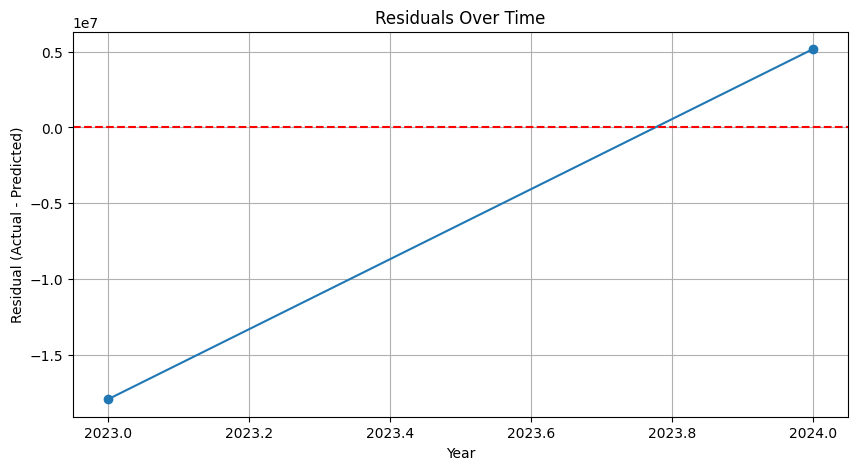

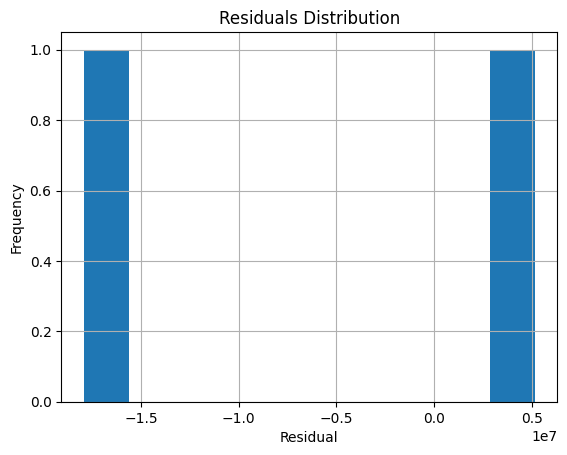

Residual Mean: -6384839.464017034


In [ ]:
# Residual Analysis
residuals = actual - predicted

# Plot residuals over time
plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Year")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.show()

# Plot histogram of residuals
residuals.hist(bins=10)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Print residual mean
print("Residual Mean:", residuals.mean())


# **Correlation Test**

Saving LZS.xlsx to LZS (1).xlsx
Cleaned columns: ['Tahun', 'Kutipan', 'Muzakki', 'GDP_growth', 'Unemployment_rate', 'Inflation', 'GNI_growth', 'Retention_rate', 'New_muzakki__growth_rate', 'Muzakki_growth_rate']

Correlation Matrix:
                            Kutipan   Muzakki  GDP_growth  Unemployment_rate  \
Kutipan                   1.000000  0.977238   -0.062757           0.418207   
Muzakki                   0.977238  1.000000   -0.061201           0.473907   
GDP_growth               -0.062757 -0.061201    1.000000          -0.552185   
Unemployment_rate         0.418207  0.473907   -0.552185           1.000000   
Inflation                -0.072443 -0.034709    0.809124          -0.326274   
GNI_growth               -0.156567 -0.149269    0.979414          -0.627370   
Retention_rate           -0.914525 -0.916832   -0.582244           0.907288   
New_muzakki__growth_rate -0.526774 -0.311137   -0.487862           0.175566   
Muzakki_growth_rate      -0.611777 -0.445688   -0.28641

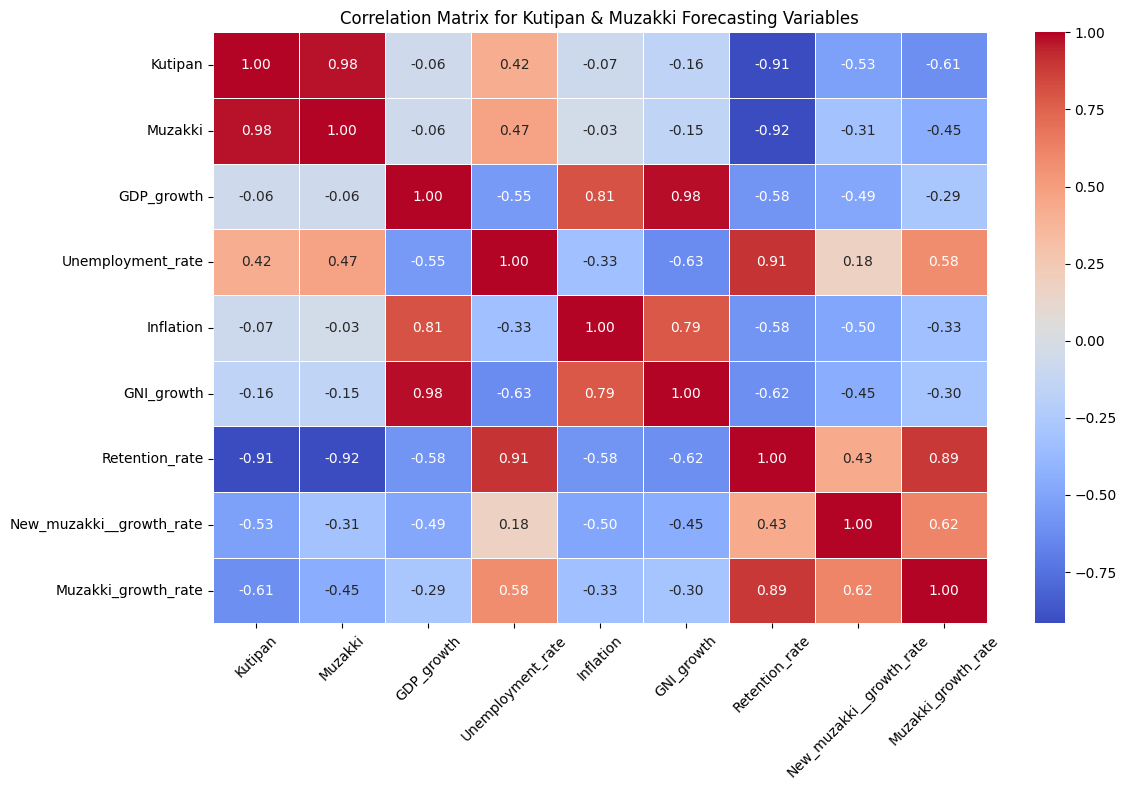

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

# Step 1: Upload your Excel file
uploaded = files.upload()
file_name = next(iter(uploaded))

# Step 2: Load the sheet (adjust if your sheet name is different)
df = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Correlation')

# Step 3: Clean column names (especially quoted or inconsistent ones)
df.columns = df.columns.str.strip().str.replace("'", "").str.replace(" ", "_")

# Optional: Preview cleaned columns
print("Cleaned columns:", df.columns.tolist())

# Step 4: Select only numeric columns to include in correlation matrix
numeric_cols = [
    'Kutipan', 'Muzakki', 'GDP_growth', 'Unemployment_rate',
    'Inflation', 'GNI_growth', 'Retention_rate',
    'New_muzakki__growth_rate',
    'Muzakki_growth_rate'
]


# Step 5: Convert to numeric (in case some were loaded as object types)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Step 6: Compute correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Print raw correlation values
print("\nCorrelation Matrix:\n", correlation_matrix)

# Step 7: Heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for Kutipan & Muzakki Forecasting Variables")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **Reference & Notes**

***source code***

https://gist.github.com/ChadFulton/82744b500a5dcb0283624c80fd10c92b?utm_source=chatgpt.com#file-nhs_example-ipynb

https://github.com/MKB-Datalab/time-series-analysis-with-SARIMAX-and-Prophet/blob/master/notebooks/02-Forecasting_with_SARIMAX.ipynb

***exo variables for customer***

https://www.google.com/search?q=exogenous+variable+for+customer+prediction&sca_esv=9cb49794e0b2005d&rlz=1C1GCEU_enMY1120MY1120&sxsrf=AE3TifPAsc57K_KGTkBZbzuHP_W_CQLcqQ%3A1752828529584&ei=cQp6aPW6I5D3seMP5uDy6Aw&ved=0ahUKEwi1t-6Og8aOAxWQe2wGHWawHM0Q4dUDCBA&uact=5&oq=exogenous+variable+for+customer+prediction&gs_lp=Egxnd3Mtd2l6LXNlcnAiKmV4b2dlbm91cyB2YXJpYWJsZSBmb3IgY3VzdG9tZXIgcHJlZGljdGlvbjIFECEYoAFI2x5QxwRY-xtwAXgAkAEAmAGdAaABpAeqAQQxMS4xuAEDyAEA-AEBmAIMoAKoB8ICChAAGLADGNYEGEfCAgQQIxgnwgIIEAAYgAQYogTCAgUQABjvBcICCBAAGKIEGIkFwgIEECEYFcICBRAhGJ8FwgIHECEYoAEYCpgDAIgGAZAGCJIHBDEwLjKgB_0usgcDOS4yuAeeB8IHBTAuOS4zyAcg&sclient=gws-wiz-serp

***correlation matrix***

https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas


Muzakki exo value


1.   growth muzakki
2.   growth new muzakki
2.   retention rate jbi

